<a href="https://colab.research.google.com/github/5234560002ebnida/nonfictioner/blob/main/support_resistence_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-4-3808874ccacf>:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'][signals['Buy Signal']] = 1
<ipython-input-4-3808874ccacf>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Position'][signals['Sell Signal']] = -1
<ipython-input-4-3808874ccacf>:109: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  plt.tight_layout()
<ipython-input-4-3808874ccacf>:109: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from current font.
  plt.tight_layout()
<ipython-input-4-3808874ccacf>:109: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current fo

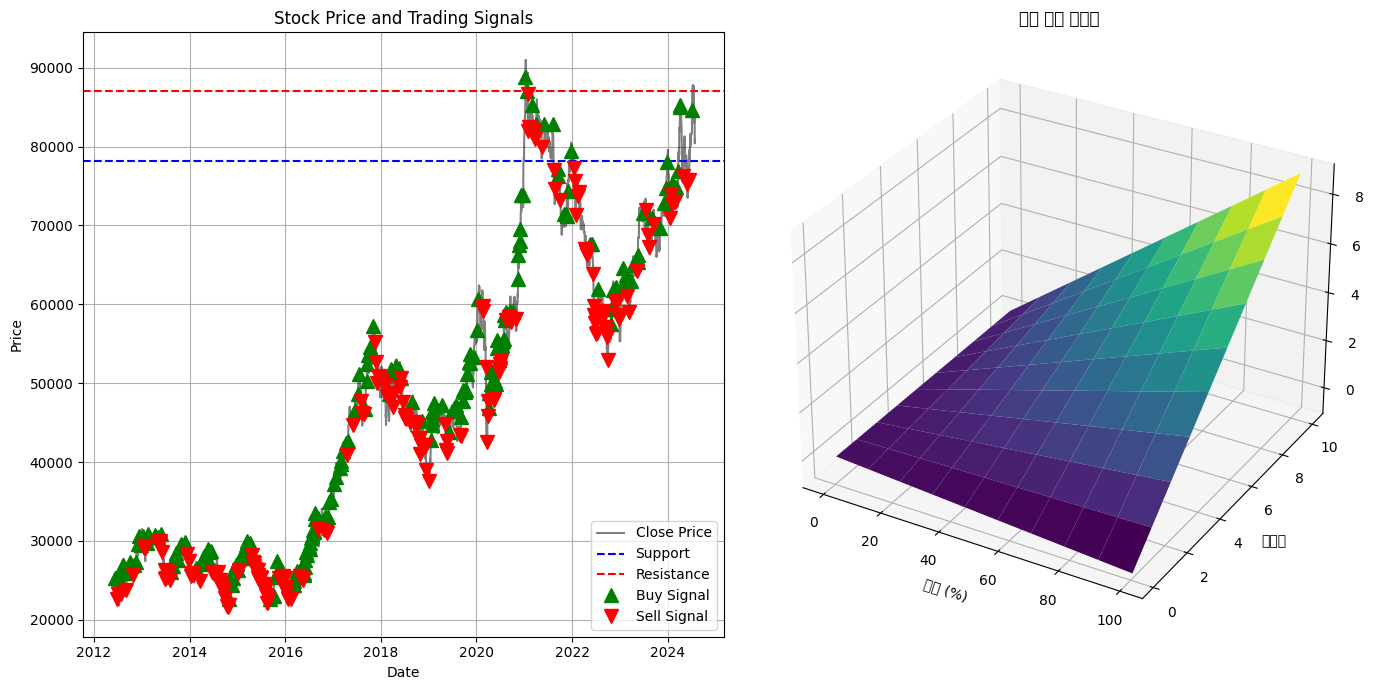

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import requests
from bs4 import BeautifulSoup

# 주식 데이터를 가져오는 함수
def get_price(symbol, count=3000, timeframe='day'):
    url = f"https://fchart.stock.naver.com/sise.nhn?symbol={symbol}&timeframe={timeframe}&count={count}&requestType=0"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "xml")
    columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = []
    items = soup.find_all('item')
    for item in items:
        row = item['data'].split('|')
        data.append(row)

    df = pd.DataFrame(data, columns=columns)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df.astype(float)

# 피벗 포인트와 지지/저항 레벨 계산 함수
def calculate_pivots(df, period=10):
    high = df['High']
    low = df['Low']
    close = df['Close']

    pivot_highs = (high.shift(period) == high.rolling(window=period*2+1, center=True).max())
    pivot_lows = (low.shift(period) == low.rolling(window=period*2+1, center=True).min())

    df['Pivot High'] = high[pivot_highs]
    df['Pivot Low'] = low[pivot_lows]

    df['Support'] = df['Pivot High'].fillna(method='ffill')  # 지지와 저항을 바꿈
    df['Resistance'] = df['Pivot Low'].fillna(method='ffill')  # 지지와 저항을 바꿈

    return df

# 매수/매도 신호 생성 함수 (확인 기준 추가)
def generate_signals(df, confirmation_percent=0.02):
    signals = pd.DataFrame(index=df.index)
    buy_signal = (df['Close'] > df['Resistance'] * (1 + confirmation_percent)) & (df['Close'].shift(1) <= df['Resistance'] * (1 + confirmation_percent))
    sell_signal = (df['Close'] < df['Support'] * (1 - confirmation_percent)) & (df['Close'].shift(1) >= df['Support'] * (1 - confirmation_percent))
    signals['Buy Signal'] = buy_signal
    signals['Sell Signal'] = sell_signal
    return signals

# 거래 결과 평가 함수
def evaluate_trades(df, signals):
    df['Position'] = 0
    df['Position'][signals['Buy Signal']] = 1
    df['Position'][signals['Sell Signal']] = -1
    df['Position'] = df['Position'].replace(to_replace=0, method='ffill')

    df['Daily Returns'] = df['Close'].pct_change()
    df['Strategy Returns'] = df['Position'].shift(1) * df['Daily Returns']

    df['Cumulative Strategy Returns'] = (df['Strategy Returns'] + 1).cumprod()
    df['Cumulative Market Returns'] = (df['Daily Returns'] + 1).cumprod()

    total_trades = df['Position'].diff().abs().sum() / 2  # 매수/매도 페어로 나누어 거래 수 계산
    profitable_trades = (df['Strategy Returns'][df['Strategy Returns'] > 0].count())
    win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0

    average_win = df['Strategy Returns'][df['Strategy Returns'] > 0].mean()
    average_loss = df['Strategy Returns'][df['Strategy Returns'] < 0].mean()
    profit_loss_ratio = -average_win / average_loss if average_loss != 0 else np.nan

    return win_rate, profit_loss_ratio

# 3D 시각화 및 기댓값 계산 함수
def plot_3d_expectations(win_rates, profit_loss_ratios, initial_capital=10000000):
    X, Y = np.meshgrid(win_rates, profit_loss_ratios)
    Z = initial_capital * (X / 100) * (Y - 1)  # 기댓값 계산 공식

    fig = plt.figure(figsize=(14, 7))

    # 2D 차트
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122, projection='3d')

    # 2D 차트: 주식 가격 및 거래 신호 시각화
    ax1.plot(df.index, df['Close'], label='Close Price', color='black', alpha=0.5)
    ax1.axhline(y=df['Support'].iloc[-1], color='blue', linestyle='--', label='Support')
    ax1.axhline(y=df['Resistance'].iloc[-1], color='red', linestyle='--', label='Resistance')

    buy_signals = df[signals['Buy Signal']]
    sell_signals = df[signals['Sell Signal']]
    ax1.plot(buy_signals.index, buy_signals['Close'], '^', markersize=10, color='green', lw=0, label='Buy Signal')
    ax1.plot(sell_signals.index, sell_signals['Close'], 'v', markersize=10, color='red', lw=0, label='Sell Signal')

    ax1.set_title('Stock Price and Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(True)

    # 3D 차트: 기댓값 시각화
    ax2.plot_surface(X, Y, Z, cmap='viridis')

    ax2.set_xlabel('승률 (%)')
    ax2.set_ylabel('손익비')
    ax2.set_zlabel('기댓값 (천만원)')
    ax2.set_title('거래 전략 기댓값')

    plt.tight_layout()
    plt.show()

# 사용 예시
symbol = '005930'  # 삼성전자 종목코드
df = get_price(symbol)
df = calculate_pivots(df)
signals = generate_signals(df)

# 거래 평가
win_rate, profit_loss_ratio = evaluate_trades(df, signals)

# 승률과 손익비의 범위 설정
win_rate_range = np.linspace(0, 100, 10)
profit_loss_ratio_range = np.linspace(0.1, 10, 10)

# 3D 시각화 및 차트 함께 보기
plot_3d_expectations(win_rate_range, profit_loss_ratio_range)



